# Courtship song of flies

Clustering annotations of sine and pulse song should yield three clear clusters:

1. _Sine_: relatively slow (150Hz), sustained oscillations
2. _Pslow_: relatively broad and symmetrical pulses with a central positive lobe flanked by two negative lobes
3. _Pfast_: shorter, asymmetrical (biphasic) pulses

We closely follow the approach in Clemens et al. (2018): Discovery of a new song mode in Drosophila reveals hidden structure in the sensory and neural drivers of behavior.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import das_unsupervised.event_utils
from io import BytesIO
import urllib.request

%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page
plt.style.use('ncb.mplstyle')

Download annotated recordings of fly song. Recording from: D Stern (2014). Reported Drosophila courtship song rhythms are artifacts of data analysis. BMC Biology. [https://www.janelia.org/lab/stern-lab/tools-reagents-data]()

In [18]:
url = 'https://github.com/janclemenslab/das_unsupervised/releases/download/v0.4/flies.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
recording = d['recording']
pulsetimes = d['pulsetimes']
sinetimes = d['sinetimes']
samplerate = d['samplerate']

Cutout and normalize short waveforms from the annotations. Normalization aligns all waveforms to their peak energy, normalizes the energy and flips the sign (the microphones used for recording the fly song are directional). The normalized pulsee waveforms should already reveal the two pulse types Pfast and Pslow.

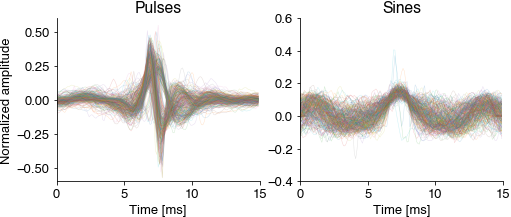

In [19]:
win_hw = 100
pulseshapes = das_unsupervised.event_utils.get_shapes(pulsetimes + win_hw, recording, win_hw)
pulseshapes = np.apply_along_axis(das_unsupervised.event_utils.normalize, axis=-1, arr=pulseshapes.T).T
pulseshapes = pulseshapes[25:-25]

sineshapes = das_unsupervised.event_utils.get_shapes(sinetimes + 2*win_hw, recording, win_hw)
sineshapes = np.apply_along_axis(das_unsupervised.event_utils.normalize, axis=-1, arr=sineshapes.T).T
sineshapes = sineshapes[25:-25]

good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

allshapes = np.concatenate((pulseshapes, sineshapes), axis=1)
good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

T = np.arange(pulseshapes.shape[0]) / samplerate * 1_000  # ms

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(T, pulseshapes, linewidth=0.5, alpha=0.2)
plt.title('Pulses')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized amplitude')

plt.subplot(122)
plt.plot(T, sineshapes, linewidth=0.5, alpha=0.2)
plt.title('Sines')
plt.xlabel('Time [ms]')
plt.show()

Embed all pulse and sine waveforms into a two-dimensional spaces using the umap method and cluster the resulting points clouds using density-based clustering (hdbscan).

In [20]:
out = umap.UMAP(min_dist=0.5, random_state=3).fit_transform(allshapes.T)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)

This results in three distinct point clouds (each point corresponds to a waveform in the UMAP space). The three cluster centroids contain a slow sustained, a broad symmetrical, and a short asymmetrical waveform.

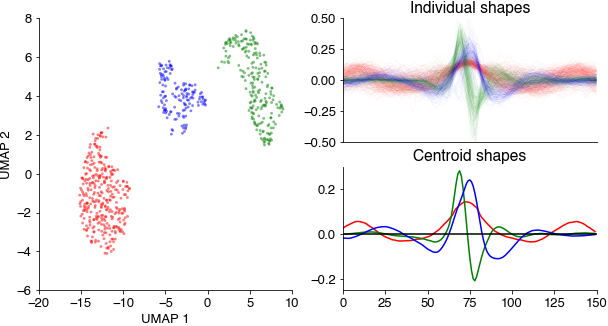

In [21]:
colors = 'rgb'

fig = plt.figure(figsize=(10, 5))

gs = fig.add_gridspec(2, 2)
ax_scatter = fig.add_subplot(gs[:, 0])
ax_individual = fig.add_subplot(gs[0, 1])
ax_centroid = fig.add_subplot(gs[1, 1])

for label, color in zip(np.unique(hdbscan_labels), colors):
    if label>=0:
        this = hdbscan_labels==label
        
        ax_scatter.scatter(out[this, 0], out[this, 1], c=color, s=8, alpha=0.5, edgecolor='none')
        ax_scatter.set_xlabel('UMAP 1')
        ax_scatter.set_ylabel('UMAP 2')
        
        ax_individual.plot(allshapes[:, this], c=color, alpha=0.2, linewidth=0.1)
        ax_individual.set_xticks([])
        ax_individual.set_ylim(-0.5, 0.5)
        ax_individual.set_title('Individual shapes')
        
        ax_centroid.plot(np.mean(allshapes[:, this], axis=1), c=color)
        ax_centroid.set_ylim(-0.25, 0.3)
        ax_centroid.set_title('Centroid shapes')
        
ax_centroid.axhline(0, c='k')
plt.show()